### <p style="font-family: Arial; color: gold; font-weight: bold;">**update by Tom Tan in 8.30.2024** </p>

# **1. Imports**
##### Brittany C. Haas and Melissa A. Hardy's jupyter notebook for automated collection of molecular descriptors and post-processing (i.e., Boltzmann average, min/max values, etc.).
##### **NOTE: Make sure to use the get_properties_environment file to set your conda environment.**

In [1]:
import re, sys, glob, io
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.colors import ColorConverter

randomstate = 42

from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole

import ipywidgets as widgets

***
# **2. Generate Atom Inputs Dataframe**
##### Portions of this section were adapted from code written Jordan P. Liles.

### <p style="font-family: Arial; color: red; font-weight: bold;"> !!! Name the same type of molecule in a unique common prefix (need to be all character) to use the following cell </p>
### <p style="font-family: Arial; color: gold; font-weight: bold;"> for example pyridine all in pyrd + digit + whatever, pyrimidine all in pyrmd + digit + whatever </p>

## &emsp;**2.1 Generate dataframe with atom numbers**
### &emsp;&emsp;Two method: <br /> &emsp;&emsp;**1. Use command line to prepare files (only in linux!)**

### &emsp;&emsp;&emsp;To create files: navigate to folder that contains all the log files you wish to analyze.

> ##### &emsp;&emsp;&emsp;module load openbabel<br /> &emsp;&emsp;&emsp;obabel *.log -osdf -m<br /> &emsp;&emsp;&emsp;ls *.log > log_ids.txt<br /> &emsp;&emsp;&emsp;cat *.sdf >> molecules.sdf<br />

##### &emsp;&emsp;&emsp;You will use the log_ids.txt and molecules.sdf files in the rest of 2.1.

### &emsp;&emsp;**2. Run the following code in python (work in windows and linux)**
##### <p style="font-family: Arial; color: red; font-weight: bold;">&emsp;&emsp;&emsp;!!!!! make sure to install openbabel.</p> &emsp;&emsp;&emsp;see https://openbabel.org/docs/Installation/install.html <br /> &emsp;&emsp;&emsp;(in ubuntu run sudo apt install openbabel), <br /> &emsp;&emsp;&emsp;testing you installation by running obable in shell

##### &emsp;&emsp;&emsp;Convert log to sdf

In [2]:
# if under linux, execute the "module load openbabel" in the terminal (seem like this is needed in some hpc server)
if sys.platform == "linux" or sys.platform == "linux2":
    !module load openbabel

!obabel *.log -osdf -m

56 molecules converted
56 files output. The first is pyrd10_conf-1.sdf


##### &emsp;&emsp;&emsp;list all *.log files in the directory

In [3]:
# list all *.log files in the directory
# we will first grep all the prefix, use regular expression to match all non-digit characters from the start of the filename
# the key will be the prefix, and the value will be a list of all the files with that prefix
log_prefix = {}
log_file_list = glob.glob("*.log")
for file in log_file_list:
    key = re.match("([a-zA-Z]+)", file).group(0)
    if key in log_prefix:
        log_prefix[key].append(file)
    else:
        log_prefix[key] = [file]
        
# sort the dict by name
for each in log_prefix:
    log_prefix[each].sort()
# sort the key of the dict
log_prefix = dict(sorted(log_prefix.items()))
        
def format_dict_print(dict):
    for key, value in dict.items():
        print(f'"{key}": {value},')

format_dict_print(log_prefix)

"pyrd": ['pyrd10_conf-1.log', 'pyrd10_conf-2.log', 'pyrd11_conf-1.log', 'pyrd12_conf-1.log', 'pyrd12_conf-2.log', 'pyrd13_conf-1.log', 'pyrd14_conf-1.log', 'pyrd15_conf-1.log', 'pyrd16_conf-1.log', 'pyrd16_conf-2.log', 'pyrd16_conf-3.log', 'pyrd17_conf-1.log', 'pyrd17_conf-2.log', 'pyrd17_conf-3.log', 'pyrd18_conf-1.log', 'pyrd18_conf-2.log', 'pyrd1_conf-1.log', 'pyrd2_conf-1.log', 'pyrd3_conf-1.log', 'pyrd4_conf-1.log', 'pyrd5_conf-1.log', 'pyrd6_conf-1.log', 'pyrd7_conf-1.log', 'pyrd7_conf-2.log', 'pyrd7_conf-3.log', 'pyrd8_conf-1.log', 'pyrd8_conf-2.log', 'pyrd9_conf-1.log', 'pyrd9_conf-2.log'],
"pyrdz": ['pyrdz1_conf-1.log', 'pyrdz2_conf-1.log', 'pyrdz3_conf-1.log', 'pyrdz3_conf-2.log', 'pyrdz3_conf-3.log'],
"pyrmd": ['pyrmd10_conf-1.log', 'pyrmd10_conf-2.log', 'pyrmd1_conf-1.log', 'pyrmd2_conf-1.log', 'pyrmd3_conf-1.log', 'pyrmd3_conf-2.log', 'pyrmd4_conf-1.log', 'pyrmd4_conf-2.log', 'pyrmd5_conf-1.log', 'pyrmd6_conf-1.log', 'pyrmd7_conf-1.log', 'pyrmd8_conf-1.log', 'pyrmd8_conf-2

##### &emsp;&emsp;&emsp;generate log_ids_prefix.txt for each prefix by writing all log filename into a single file name log_ids_ + prefix + .txt

In [4]:
# generate log_ids_prefix.txt for each prefix,
output_file_prefix = "log_ids_"
for key in log_prefix:
    with open(output_file_prefix + key + ".txt", "w") as f:
        for item in log_prefix[key]:
            f.write("%s\n" % item)

##### &emsp;&emsp;&emsp;list all sdf files in the directory, pipe content of those with a common prefix to a file name molecules_prefix.sdf

In [5]:
# list all sdf files in the directory, pipe those with a common prefix to a file name molecules_prefix.sdf

# we will first grep all the prefix, use regular expression to match all non-digit characters from the start of the filename
# the key will be the prefix, and the value will be a list of all the files with that prefix
sdf_prefix = {}
log_file_list = glob.glob("*.sdf")
for file in log_file_list:
    key = re.match("([a-zA-Z]+)", file).group(0)
    # check this against the key of prefix dictionary, if not present, skip
    if key in log_prefix:
        if key in sdf_prefix:
            sdf_prefix[key].append(file)
        else:
            sdf_prefix[key] = [file]

# sort the dict by name
for each in sdf_prefix:
    sdf_prefix[each].sort()
# sort the key of the dict
sdf_prefix = dict(sorted(sdf_prefix.items()))

format_dict_print(sdf_prefix)

# read the sdf files, pipe their contents to a single file named molecules_prefix.sdf
output_file_prefix = "molecules_"
for key in sdf_prefix:
    with open(output_file_prefix + key + ".sdf", "w") as f:
        for sdf_file in sdf_prefix[key]:
            with open(sdf_file, "r") as f2:
                f.write(f2.read())
            print(f"pipe {sdf_file} to {output_file_prefix + key}.sdf")

"pyrd": ['pyrd10_conf-1.sdf', 'pyrd10_conf-2.sdf', 'pyrd11_conf-1.sdf', 'pyrd12_conf-1.sdf', 'pyrd12_conf-2.sdf', 'pyrd13_conf-1.sdf', 'pyrd14_conf-1.sdf', 'pyrd15_conf-1.sdf', 'pyrd16_conf-1.sdf', 'pyrd16_conf-2.sdf', 'pyrd16_conf-3.sdf', 'pyrd17_conf-1.sdf', 'pyrd17_conf-2.sdf', 'pyrd17_conf-3.sdf', 'pyrd18_conf-1.sdf', 'pyrd18_conf-2.sdf', 'pyrd1_conf-1.sdf', 'pyrd2_conf-1.sdf', 'pyrd3_conf-1.sdf', 'pyrd4_conf-1.sdf', 'pyrd5_conf-1.sdf', 'pyrd6_conf-1.sdf', 'pyrd7_conf-1.sdf', 'pyrd7_conf-2.sdf', 'pyrd7_conf-3.sdf', 'pyrd8_conf-1.sdf', 'pyrd8_conf-2.sdf', 'pyrd9_conf-1.sdf', 'pyrd9_conf-2.sdf'],
"pyrdz": ['pyrdz1_conf-1.sdf', 'pyrdz2_conf-1.sdf', 'pyrdz3_conf-1.sdf', 'pyrdz3_conf-2.sdf', 'pyrdz3_conf-3.sdf'],
"pyrmd": ['pyrmd10_conf-1.sdf', 'pyrmd10_conf-2.sdf', 'pyrmd1_conf-1.sdf', 'pyrmd2_conf-1.sdf', 'pyrmd3_conf-1.sdf', 'pyrmd3_conf-2.sdf', 'pyrmd4_conf-1.sdf', 'pyrmd4_conf-2.sdf', 'pyrmd5_conf-1.sdf', 'pyrmd6_conf-1.sdf', 'pyrmd7_conf-1.sdf', 'pyrmd8_conf-1.sdf', 'pyrmd8_conf-2

***
# **3.Define SMARTS substructure**

### <p style="font-family: Arial; color: gold"> Draw the common substructure (with general atoms) in Chemdraw and copy as SMILES (this will generate a SMARTS string), edit the common_structure_list.

"pyrd": 


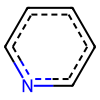

"pyrdz": 


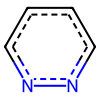

"pyrmd": 


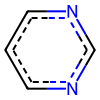

"pyrz": 


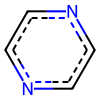

In [6]:
common_structure_list = {}

for key in log_prefix:
    structure_file = key + ".cdxml"
    substructure = Chem.MolsFromCDXMLFile(structure_file)
    # output to Smarts format
    temp_smarts = Chem.MolToSmarts(substructure[0])
    # reparse the Smarts, this is in case the structure from the cdxml file is not the same as from the SMILES string
    substructure = Chem.MolFromSmarts(temp_smarts)
    # add the substructure to the dictionary
    common_structure_list[key] = substructure

for key, value in common_structure_list.items():
    print(f'"{key}": ')
    img = Chem.Draw.MolToImage(value, size=(100, 100))
    # display the image in juptyer notebook
    display(img)

## &emsp;**3.1 Generate preliminary dataframe**
#### &emsp; This will generate common_structure_ + prefix .png with the common structure highlight and labeled. <br> &emsp; This label is the same as the one in GaussView so you don't need to use GaussView now. <br> &emsp; it will also output a dataframe mapping the common structure atom to the corresponding atom label in GaussView for easier atom reassignment.
#### <p style="font-family: Arial; color: red; font-weight: bold;"> &emsp; !!!Be aware: I add the atom label in each cell for easier atom reassignment. For example a cell change from just a single number from 7 to C7. You might need to adjust you code if you are only expecting number in each cell</p>

##### example with common_structure_pyrz.png <br> ![common_structure_pyrz](./common_structure_pyrz.png)

In [7]:
# generate a list of molecules using RDkit
all_compounds_list = {}
for prefix in log_prefix:
    all_compounds_list[prefix] = Chem.SDMolSupplier(
        "molecules_" + prefix + ".sdf", removeHs=False
    )
# molecules.sdf is generated with the instructions above
# it is a single sdf that contains the structures/atom numbers etc. for every molecule you will analyze


def draw_grid_image(img_list, title_list, num_cols, item_prefix, save_image_prefix):
    num_images = len(img_list)
    num_rows = (
        num_images + num_cols - 1
    ) // num_cols  # Calculate number of rows needed

    plt.figure(figsize=(15, 5 * num_rows))

    for i in range(num_images):
        plt.subplot(num_rows, num_cols, i + 1)
        plt.imshow(img_list[i])
        plt.axis("on")  # Turn on the axis to show grid lines
        plt.grid(True)  # Enable grid lines
        plt.title(title_list[i], fontsize=20)
        plt.xticks([])  # Remove x-ticks
        plt.yticks([])  # Remove y-ticks

    # Adjust layout to make sure everything fits and display the grid
    plt.tight_layout()
    # save the grid image to a file
    plt.savefig(save_image_prefix + item_prefix + ".png")
    # don't display the image in the notebook
    plt.close()


def search_for_substructure(all_compounds, substructure, prefix):
    # uses RDKit to search for the substructure in each compound you will analyze
    atoms = []
    img_list = []
    for molecule in all_compounds:
        if molecule is not None:
            submatch = molecule.GetSubstructMatches(substructure)  # find substructure
            matchlist = list(
                [item for sublist in submatch for item in sublist]
            )  # list of zero-indexed atom numbers

            # !this is specific to this project which is chlorination on the alkyl side chain on the substrucutre, hence we care about the alkyl side chain
            # now what we need to do, is to search atoms that are connected to the current found substructure which are also not part of the current substructure
            # they must be a carbon atom and its neighbors have to have at least one hydrogen and all bond must be single bond
            connected_atoms = []
            for atom in matchlist:
                for neighbor in molecule.GetAtomWithIdx(atom).GetNeighbors():
                    # filter neighbor that is not in the matchlist
                    if (
                        neighbor.GetSymbol() == "C"
                        and neighbor.GetIdx() not in matchlist
                    ):
                        # check if all the bonds are single bond
                        if (
                            neighbor.GetBonds() is not None  # check if there is a bond
                            and neighbor.GetTotalNumHs(includeNeighbors=True)
                            > 0  # check if there is at least one hydrogen
                            and all(
                                [
                                    bond.GetBondType() == Chem.rdchem.BondType.SINGLE
                                    for bond in neighbor.GetBonds()
                                ]  # check if all bonds are single bond
                            )
                        ):
                            connected_atoms.append(neighbor.GetIdx())
                            # append the substructure atom that is connected to the current atom
                            connected_atoms.append(atom)
            # !this will result in the substructure atom that is connected to alkyl side chain appear twice in the connected_atoms list and the matchlist
            # !this is fine since we can assign two new labels to the same atom during reassignment
            # !this is done because sometime we have atom label flipped due to symmetry, and I don't want to go through the trouble of rotating the molecule label

            # append the connected atoms to the matchlist
            matchlist.extend(connected_atoms)

            match_atom = [
                molecule.GetAtomWithIdx(x).GetSymbol() for x in matchlist
            ]  # find the corresponding atom for each atom number
            match_idx = [
                x + 1 for x in matchlist
            ]  # this line changes from 0-indexed to 1-indexed (for Gaussian)
            match_combined = [
                str(match_atom[i]) + str(match_idx[i]) for i in range(len(match_atom))
            ]  # combine atom symbol and number

            atoms.append(
                match_combined
            )  # append 1-indexed list to atoms (a list of lists)

            # add a label to the atom that is being matched
            for atom in matchlist:
                molecule.GetAtomWithIdx(atom).SetProp(
                    "atomLabel", match_combined[matchlist.index(atom)]
                )  # label the atom being matched

            # now create a grid image of all the molecules, label the atom being matched
            # the atom that had the property name GaussianMap added to it will be labeled
            # we will draw each molecule with the atom number labeled and the substructure highlighted and then combine them into a grid image with captions of the file name
            Chem.rdDepictor.Compute2DCoords(molecule)

            # Prepare the highlight color dictionary
            highlight_colors = {}
            for atom in matchlist:
                if atom in connected_atoms:
                    highlight_colors[atom] = ColorConverter().to_rgb("gold")
                else:
                    highlight_colors[atom] = ColorConverter().to_rgb("aqua")

            # Create a drawer
            drawer = Chem.Draw.rdMolDraw2D.MolDraw2DCairo(
                500, 500
            )  # Use Cairo backend for drawing
            drawer.drawOptions().continuousHighlight = True
            # Prepare highlight dictionary
            drawer.DrawMolecule(
                molecule, highlightAtoms=matchlist, highlightAtomColors=highlight_colors
            )
            drawer.FinishDrawing()

            png_data = drawer.GetDrawingText()
            img = Image.open(io.BytesIO(png_data))
            img_list.append(img)

    # this loop extracts log names from log_ids and splits them to the desired format
    filenames = open(
        "log_ids_" + prefix + ".txt", "r"
    )  # it is a text file that contains the file name for every molecule you will analyze
    # it is a text file that contains the file name for every molecule you will analyze
    list_of_filenames = [
        (line.strip()).split() for line in filenames
    ]  # list of the file names (each of which includes all conformers)
    list_of_files = []
    for filename in list_of_filenames:
        file = filename[0].split(".")
        list_of_files.append(file[0])
    filenames.close()

    # put the atom numbers for the substructure for each log file into a dataframe
    prelim_df = pd.DataFrame(atoms)
    prelim_df.insert(0, column="log_name", value=list_of_files)

    draw_grid_image(img_list, list_of_files, 3, prefix, "common_structure_")

    return prelim_df


mappped_df = {}

for prefix in log_prefix:
    mappped_df[prefix] = search_for_substructure(
        all_compounds_list[prefix], common_structure_list[prefix], prefix
    )
    display(mappped_df[prefix])

,log_name,0,1,2,3,4,5,6,7
0,pyrd10_conf-1,C6,C5,N4,C3,C12,C7,C2,C3
1,pyrd10_conf-2,C6,C5,N4,C3,C12,C7,C2,C3
2,pyrd11_conf-1,C4,C3,N12,C11,C10,C5,C2,C3
3,pyrd12_conf-1,C3,C4,N5,C6,C7,C12,C2,C3
4,pyrd12_conf-2,C3,C4,N5,C6,C7,C12,C2,C3
5,pyrd13_conf-1,C5,C4,N3,C2,C7,C6,C1,C2
6,pyrd14_conf-1,C2,C7,N6,C5,C4,C3,C1,C2
7,pyrd15_conf-1,C3,C4,N5,C6,C7,C2,C1,C2
8,pyrd16_conf-1,C6,C5,N4,C3,C8,C7,C2,C3
9,pyrd16_conf-2,C6,C5,N4,C3,C8,C7,C2,C3


,log_name,0,1,2,3,4,5,6,7
0,pyrdz1_conf-1,C2,N7,N6,C5,C4,C3,C1,C2
1,pyrdz2_conf-1,C3,N4,N5,C6,C7,C2,C1,C2
2,pyrdz3_conf-1,C3,N8,N7,C6,C5,C4,C2,C3
3,pyrdz3_conf-2,C3,N8,N7,C6,C5,C4,C2,C3
4,pyrdz3_conf-3,C3,N8,N7,C6,C5,C4,C2,C3


[13:44:27] The 2 defining bonds for an atropisomer are co-planar - atoms are: 1 2
[13:44:27] The 2 defining bonds for an atropisomer are co-planar - atoms are: 1 6
[13:44:27] The 2 defining bonds for an atropisomer are co-planar - atoms are: 2 3
[13:44:27] The 2 defining bonds for an atropisomer are co-planar - atoms are: 2 11


,log_name,0,1,2,3,4,5,6,7
0,pyrmd10_conf-1,C6,N5,C4,C3,C8,N7,C2,C3
1,pyrmd10_conf-2,C6,N5,C4,C3,C8,N7,C2,C3
2,pyrmd1_conf-1,C2,N11,C10,C5,C4,N3,C1,C2
3,pyrmd2_conf-1,None,None,None,None,None,None,None,None
4,pyrmd3_conf-1,C3,N12,C11,C10,C5,N4,C2,C3
5,pyrmd3_conf-2,C3,N4,C5,C10,C11,N12,C2,C3
6,pyrmd4_conf-1,None,None,None,None,None,None,None,None
7,pyrmd4_conf-2,None,None,None,None,None,None,None,None
8,pyrmd5_conf-1,C2,N3,C4,C5,C6,N7,C1,C2
9,pyrmd6_conf-1,C4,N3,C2,C7,C6,N5,C1,C2


,log_name,0,1,2,3,4,5,6,7
0,pyrz1_conf-1,C2,C11,N10,C5,C4,N3,C1,C2
1,pyrz2_conf-1,C3,C12,N11,C10,C5,N4,C2,C3
2,pyrz2_conf-2,C3,C12,N11,C10,C5,N4,C2,C3
3,pyrz2_conf-3,C3,C12,N11,C10,C5,N4,C2,C3
4,pyrz3_conf-1,C2,C7,N6,C5,C4,N3,C1,C2
5,pyrz4_conf-1,C3,C8,N7,C6,C5,N4,C2,C3
6,pyrz4_conf-2,C3,C8,N7,C6,C5,N4,C2,C3


## &emsp;**3.2 Reassign atom labels**

### <p style="font-family: Arial; color: gold; font-weight: bold;"> &emsp;&emsp;**User input required:** </p>

##### &emsp;&emsp; Check the preliminary dataframe displayed above and the common_structure_prefix.png. You will see that the same common structure atom is labeled differently in each molecule (usually the same in each conformers). We need to address this by relabel atoms in the common structure to a new label that is consistent across all molecules.
##### &emsp;&emsp; Run the follow cell, for each prefix it will prompt you to input the new label for each atom in the common structure. <br> &emsp;&emsp; The input box will show the header in the current mapping dataframe, change it to the new label you want to assign to the atom. It's recommand to include the atom type in the label, for example C7, N1, etc.


##### &emsp;&emsp; As you press submit, a images of the newly relabeled common structure will be saved to common_structure_reassigned_prefix.png. <br> &emsp;&emsp; You can open this up and compared side by side to the previous common_structure_prefix.png to make sure the relabeling is correct.

In [8]:
# go through each dataframe in mappped_df, drop row with None
for key in mappped_df:
    # check if there is any invalid value in a row, print a warning
    invalid_rows = mappped_df[key].isnull().any(axis=1)
    if invalid_rows.any():
        print(f"Warning: invalid value in {key}, content: {mappped_df[key][invalid_rows]}")
    # drop the row with None
    mappped_df[key].dropna(inplace=True, axis=0, how="any")
    # reset the index
    mappped_df[key] = mappped_df[key].reset_index(drop=True)

3  pyrmd2_conf-1  None  None  None  None  None  None  None  None
6  pyrmd4_conf-1  None  None  None  None  None  None  None  None
7  pyrmd4_conf-2  None  None  None  None  None  None  None  None


In [9]:
mappped_df

{'pyrd':          log_name    0    1    2    3    4    5   6   7
 0   pyrd10_conf-1   C6   C5   N4   C3  C12   C7  C2  C3
 1   pyrd10_conf-2   C6   C5   N4   C3  C12   C7  C2  C3
 2   pyrd11_conf-1   C4   C3  N12  C11  C10   C5  C2  C3
 3   pyrd12_conf-1   C3   C4   N5   C6   C7  C12  C2  C3
 4   pyrd12_conf-2   C3   C4   N5   C6   C7  C12  C2  C3
 5   pyrd13_conf-1   C5   C4   N3   C2   C7   C6  C1  C2
 6   pyrd14_conf-1   C2   C7   N6   C5   C4   C3  C1  C2
 7   pyrd15_conf-1   C3   C4   N5   C6   C7   C2  C1  C2
 8   pyrd16_conf-1   C6   C5   N4   C3   C8   C7  C2  C3
 9   pyrd16_conf-2   C6   C5   N4   C3   C8   C7  C2  C3
 10  pyrd16_conf-3   C6   C5   N4   C3   C8   C7  C2  C3
 11  pyrd17_conf-1   C3   C8   N7   C6   C5   C4  C2  C3
 12  pyrd17_conf-2   C3   C8   N7   C6   C5   C4  C2  C3
 13  pyrd17_conf-3   C3   C8   N7   C6   C5   C4  C2  C3
 14  pyrd18_conf-1   C4   C5   N6   C7   C8   C3  C2  C3
 15  pyrd18_conf-2   C4   C5   N6   C7   C8   C3  C2  C3
 16   pyrd1_conf-1   C5

In [10]:
# a example of the atom_labels, this is not used in the code
atom_labels = {
    "log_name": "log_name",
    0: "C4",
    1: "C5",
    2: "N1",
    3: "C1",
    4: "C2",
    5: "C3",
}

atom_label_mappings_dict = {}
display_buttons = {}


def create_button_handler(prefix, atom_labels):
    def on_submit_button_clicked(b):
        # Collect the inputs into the atom_labels dictionary
        atom_label_mappings_dict[prefix] = {
            col: atom_labels[col].value for col in mappped_df[prefix].columns
        }
        print(f"Atom labels for prefix '{prefix}': {atom_label_mappings_dict[prefix]}")

        img_list = []

        # at the same time, for each row, load the molecule from the sdf file, add the atom labels based on the atom_labels_dict and highlight the substructure
        for index, row in mappped_df[prefix].iterrows():
            log_file = row["log_name"] + ".sdf"
            molecule = Chem.SDMolSupplier(log_file, removeHs=False)[0]
            Chem.rdDepictor.Compute2DCoords(molecule)

            highlight_atoms = []

            # the header will be the new atom labels the cell content is the atom symbol + 1-indexed atom number
            for col in atom_label_mappings_dict[prefix]:
                if col == "log_name":
                    continue
                atom_num = row[col]
                # parse the atom number to get the atom index
                atom_num = int(re.findall(r"\d+", atom_num)[0]) - 1
                highlight_atoms.append(atom_num)
                molecule.GetAtomWithIdx(int(atom_num)).SetProp(
                    "atomLabel", atom_label_mappings_dict[prefix][col]
                )

            # Prepare the highlight color dictionary, make the last two atom gold, other aqua
            highlight_colors = {}
            for atom in highlight_atoms[:-2]:
                highlight_colors[atom] = ColorConverter().to_rgb("aqua")
            for atom in highlight_atoms[-2:]:
                highlight_colors[atom] = ColorConverter().to_rgb("gold")

            # Create a drawer
            drawer = Chem.Draw.rdMolDraw2D.MolDraw2DCairo(
                500, 500
            )  # Use Cairo backend for drawing
            drawer.drawOptions().continuousHighlight = True
            # Prepare highlight dictionary
            drawer.DrawMolecule(
                molecule,
                highlightAtoms=highlight_atoms,
                highlightAtomColors=highlight_colors,
            )
            drawer.FinishDrawing()

            png_data = drawer.GetDrawingText()
            img = Image.open(io.BytesIO(png_data))
            img_list.append(img)

        draw_grid_image(
            img_list,
            mappped_df[prefix]["log_name"],
            3,
            prefix,
            "common_structure_reassigned_",
        )

    return on_submit_button_clicked


for prefix in log_prefix:
    atom_labels = {}
    print(f"Please input atom labels for prefix '{prefix}':")
    # Display the DataFrame to the user
    display(mappped_df[prefix])

    # Create input boxes for each column in the DataFrame
    for col in mappped_df[prefix].columns:
        atom_label = widgets.Text(
            value="log_name" if col == "log_name" else "",
            placeholder=f"Enter label for {col}",
            description=f"{col}:",
            disabled=False,
        )
        display(atom_label)
        atom_labels[col] = atom_label

    # Add a button to submit the inputs
    display_buttons[prefix] = widgets.Button(description="Submit")

    # Create and attach the button handler
    display_buttons[prefix].on_click(create_button_handler(prefix, atom_labels))
    display(display_buttons[prefix])

Please input atom labels for prefix 'pyrd':


,log_name,0,1,2,3,4,5,6,7
0,pyrd10_conf-1,C6,C5,N4,C3,C12,C7,C2,C3
1,pyrd10_conf-2,C6,C5,N4,C3,C12,C7,C2,C3
2,pyrd11_conf-1,C4,C3,N12,C11,C10,C5,C2,C3
3,pyrd12_conf-1,C3,C4,N5,C6,C7,C12,C2,C3
4,pyrd12_conf-2,C3,C4,N5,C6,C7,C12,C2,C3
5,pyrd13_conf-1,C5,C4,N3,C2,C7,C6,C1,C2
6,pyrd14_conf-1,C2,C7,N6,C5,C4,C3,C1,C2
7,pyrd15_conf-1,C3,C4,N5,C6,C7,C2,C1,C2
8,pyrd16_conf-1,C6,C5,N4,C3,C8,C7,C2,C3
9,pyrd16_conf-2,C6,C5,N4,C3,C8,C7,C2,C3


Text(value='log_name', description='log_name:', placeholder='Enter label for log_name')

Text(value='', description='0:', placeholder='Enter label for 0')

Text(value='', description='1:', placeholder='Enter label for 1')

Text(value='', description='2:', placeholder='Enter label for 2')

Text(value='', description='3:', placeholder='Enter label for 3')

Text(value='', description='4:', placeholder='Enter label for 4')

Text(value='', description='5:', placeholder='Enter label for 5')

Text(value='', description='6:', placeholder='Enter label for 6')

Text(value='', description='7:', placeholder='Enter label for 7')

Button(description='Submit', style=ButtonStyle())

Please input atom labels for prefix 'pyrdz':


,log_name,0,1,2,3,4,5,6,7
0,pyrdz1_conf-1,C2,N7,N6,C5,C4,C3,C1,C2
1,pyrdz2_conf-1,C3,N4,N5,C6,C7,C2,C1,C2
2,pyrdz3_conf-1,C3,N8,N7,C6,C5,C4,C2,C3
3,pyrdz3_conf-2,C3,N8,N7,C6,C5,C4,C2,C3
4,pyrdz3_conf-3,C3,N8,N7,C6,C5,C4,C2,C3


Text(value='log_name', description='log_name:', placeholder='Enter label for log_name')

Text(value='', description='0:', placeholder='Enter label for 0')

Text(value='', description='1:', placeholder='Enter label for 1')

Text(value='', description='2:', placeholder='Enter label for 2')

Text(value='', description='3:', placeholder='Enter label for 3')

Text(value='', description='4:', placeholder='Enter label for 4')

Text(value='', description='5:', placeholder='Enter label for 5')

Text(value='', description='6:', placeholder='Enter label for 6')

Text(value='', description='7:', placeholder='Enter label for 7')

Button(description='Submit', style=ButtonStyle())

Please input atom labels for prefix 'pyrmd':


,log_name,0,1,2,3,4,5,6,7
0,pyrmd10_conf-1,C6,N5,C4,C3,C8,N7,C2,C3
1,pyrmd10_conf-2,C6,N5,C4,C3,C8,N7,C2,C3
2,pyrmd1_conf-1,C2,N11,C10,C5,C4,N3,C1,C2
3,pyrmd3_conf-1,C3,N12,C11,C10,C5,N4,C2,C3
4,pyrmd3_conf-2,C3,N4,C5,C10,C11,N12,C2,C3
5,pyrmd5_conf-1,C2,N3,C4,C5,C6,N7,C1,C2
6,pyrmd6_conf-1,C4,N3,C2,C7,C6,N5,C1,C2
7,pyrmd7_conf-1,C5,N4,C3,C2,C7,N6,C1,C2
8,pyrmd8_conf-1,C3,N4,C5,C6,C7,N8,C2,C3
9,pyrmd8_conf-2,C3,N8,C7,C6,C5,N4,C2,C3


Text(value='log_name', description='log_name:', placeholder='Enter label for log_name')

Text(value='', description='0:', placeholder='Enter label for 0')

Text(value='', description='1:', placeholder='Enter label for 1')

Text(value='', description='2:', placeholder='Enter label for 2')

Text(value='', description='3:', placeholder='Enter label for 3')

Text(value='', description='4:', placeholder='Enter label for 4')

Text(value='', description='5:', placeholder='Enter label for 5')

Text(value='', description='6:', placeholder='Enter label for 6')

Text(value='', description='7:', placeholder='Enter label for 7')

Button(description='Submit', style=ButtonStyle())

Please input atom labels for prefix 'pyrz':


,log_name,0,1,2,3,4,5,6,7
0,pyrz1_conf-1,C2,C11,N10,C5,C4,N3,C1,C2
1,pyrz2_conf-1,C3,C12,N11,C10,C5,N4,C2,C3
2,pyrz2_conf-2,C3,C12,N11,C10,C5,N4,C2,C3
3,pyrz2_conf-3,C3,C12,N11,C10,C5,N4,C2,C3
4,pyrz3_conf-1,C2,C7,N6,C5,C4,N3,C1,C2
5,pyrz4_conf-1,C3,C8,N7,C6,C5,N4,C2,C3
6,pyrz4_conf-2,C3,C8,N7,C6,C5,N4,C2,C3


Text(value='log_name', description='log_name:', placeholder='Enter label for log_name')

Text(value='', description='0:', placeholder='Enter label for 0')

Text(value='', description='1:', placeholder='Enter label for 1')

Text(value='', description='2:', placeholder='Enter label for 2')

Text(value='', description='3:', placeholder='Enter label for 3')

Text(value='', description='4:', placeholder='Enter label for 4')

Text(value='', description='5:', placeholder='Enter label for 5')

Text(value='', description='6:', placeholder='Enter label for 6')

Text(value='', description='7:', placeholder='Enter label for 7')

Button(description='Submit', style=ButtonStyle())

Atom labels for prefix 'pyrd': {'log_name': 'log_name', 0: 'C3', 1: 'C4', 2: 'N1', 3: 'C5', 4: 'C6', 5: 'C7', 6: 'C1', 7: 'C2'}
Atom labels for prefix 'pyrdz': {'log_name': 'log_name', 0: 'C3', 1: 'N1', 2: 'N2', 3: 'C4', 4: 'C5', 5: 'C6', 6: 'C1', 7: 'C2'}
Atom labels for prefix 'pyrmd': {'log_name': 'log_name', 0: 'C3', 1: 'N1', 2: 'C4', 3: 'C5', 4: 'C6', 5: 'N2', 6: 'C1', 7: 'C2'}
Atom labels for prefix 'pyrz': {'log_name': 'log_name', 0: 'C3', 1: 'C4', 2: 'N1', 3: 'C5', 4: 'C6', 5: 'N2', 6: 'C1', 7: 'C2'}


##### You can check the new mapping dictionary by running the next cell.
### <p style="font-family: Arial; color: gold; font-weight: bold;"> **User input required in above cell output!!!** </p>

In [12]:
# check the length of the dict, if it is not equal to the length of the log_prefix, throw a exception indicating that the user needs to input all the atom labels before proceeding
if len(atom_label_mappings_dict) != len(log_prefix):
    raise Exception(
        f"Please input atom labels for all prefixes before proceeding to the next step. You have inputted the following prefixes: {list(atom_label_mappings_dict.keys())}\n Please input the atom labels for the following prefixes: {set(log_prefix.keys()) - set(atom_label_mappings_dict.keys())}"
    )

format_dict_print(atom_label_mappings_dict)

"pyrd": {'log_name': 'log_name', 0: 'C3', 1: 'C4', 2: 'N1', 3: 'C5', 4: 'C6', 5: 'C7', 6: 'C1', 7: 'C2'},
"pyrdz": {'log_name': 'log_name', 0: 'C3', 1: 'N1', 2: 'N2', 3: 'C4', 4: 'C5', 5: 'C6', 6: 'C1', 7: 'C2'},
"pyrmd": {'log_name': 'log_name', 0: 'C3', 1: 'N1', 2: 'C4', 3: 'C5', 4: 'C6', 5: 'N2', 6: 'C1', 7: 'C2'},
"pyrz": {'log_name': 'log_name', 0: 'C3', 1: 'C4', 2: 'N1', 3: 'C5', 4: 'C6', 5: 'N2', 6: 'C1', 7: 'C2'},


## &emsp;**3.3 Generate labeled dataframe**

##### &emsp;&emsp;**NOTE: it is very important you assign these correctly otherwise the properties you collect will be for the wrong atoms and not produce meaningful correlations.** <br> &emsp;&emsp;Numbering for different conformers of the same compounds will likely be the same (but may not be for some symmetrical groups).

In [13]:
# rename columns using the user input above
for prefix in log_prefix:
    mappped_df[prefix] = mappped_df[prefix].rename(columns=atom_label_mappings_dict[prefix])
    display(mappped_df[prefix])

    # you can use this to clean up the table if you have more atoms in your substructure than you want to collect descriptors for
    # mappped_df[prefix] = mappped_df[prefix].drop(columns= ['C4', 'C1'])
    # display(mappped_df[prefix])

,log_name,C3,C4,N1,C5,C6,C7,C1,C2
0,pyrd10_conf-1,C6,C5,N4,C3,C12,C7,C2,C3
1,pyrd10_conf-2,C6,C5,N4,C3,C12,C7,C2,C3
2,pyrd11_conf-1,C4,C3,N12,C11,C10,C5,C2,C3
3,pyrd12_conf-1,C3,C4,N5,C6,C7,C12,C2,C3
4,pyrd12_conf-2,C3,C4,N5,C6,C7,C12,C2,C3
5,pyrd13_conf-1,C5,C4,N3,C2,C7,C6,C1,C2
6,pyrd14_conf-1,C2,C7,N6,C5,C4,C3,C1,C2
7,pyrd15_conf-1,C3,C4,N5,C6,C7,C2,C1,C2
8,pyrd16_conf-1,C6,C5,N4,C3,C8,C7,C2,C3
9,pyrd16_conf-2,C6,C5,N4,C3,C8,C7,C2,C3


,log_name,C3,N1,N2,C4,C5,C6,C1,C2
0,pyrdz1_conf-1,C2,N7,N6,C5,C4,C3,C1,C2
1,pyrdz2_conf-1,C3,N4,N5,C6,C7,C2,C1,C2
2,pyrdz3_conf-1,C3,N8,N7,C6,C5,C4,C2,C3
3,pyrdz3_conf-2,C3,N8,N7,C6,C5,C4,C2,C3
4,pyrdz3_conf-3,C3,N8,N7,C6,C5,C4,C2,C3


,log_name,C3,N1,C4,C5,C6,N2,C1,C2
0,pyrmd10_conf-1,C6,N5,C4,C3,C8,N7,C2,C3
1,pyrmd10_conf-2,C6,N5,C4,C3,C8,N7,C2,C3
2,pyrmd1_conf-1,C2,N11,C10,C5,C4,N3,C1,C2
3,pyrmd3_conf-1,C3,N12,C11,C10,C5,N4,C2,C3
4,pyrmd3_conf-2,C3,N4,C5,C10,C11,N12,C2,C3
5,pyrmd5_conf-1,C2,N3,C4,C5,C6,N7,C1,C2
6,pyrmd6_conf-1,C4,N3,C2,C7,C6,N5,C1,C2
7,pyrmd7_conf-1,C5,N4,C3,C2,C7,N6,C1,C2
8,pyrmd8_conf-1,C3,N4,C5,C6,C7,N8,C2,C3
9,pyrmd8_conf-2,C3,N8,C7,C6,C5,N4,C2,C3


,log_name,C3,C4,N1,C5,C6,N2,C1,C2
0,pyrz1_conf-1,C2,C11,N10,C5,C4,N3,C1,C2
1,pyrz2_conf-1,C3,C12,N11,C10,C5,N4,C2,C3
2,pyrz2_conf-2,C3,C12,N11,C10,C5,N4,C2,C3
3,pyrz2_conf-3,C3,C12,N11,C10,C5,N4,C2,C3
4,pyrz3_conf-1,C2,C7,N6,C5,C4,N3,C1,C2
5,pyrz4_conf-1,C3,C8,N7,C6,C5,N4,C2,C3
6,pyrz4_conf-2,C3,C8,N7,C6,C5,N4,C2,C3


##### &emsp;&emsp; Save atom map to Excel, they will be named atom_map_prefix.xlsx

In [14]:
for prefix in log_prefix:
    writer = pd.ExcelWriter(f"{prefix}_atom_map.xlsx")
    mappped_df[prefix].to_excel(writer)
    writer.close()

# <p style="font-family: Arial; color: gold; font-weight: bold;"> Now we have completed the preprocessing of the atom map, we can move on to the next step to proprocess the properties of the molecule, see get_properties_notebook_ + prefex notebook </p>